# INFORMASI
Ini adalah proses cleaning dan penyiapan data komentar YouTube LLM-based-labeled untuk dipergunakan sebagai target domain data. Output dari code ini adalah csv yang berisi kalimat hasil preprocessing yang disesuaikan untuk BERT dan DL/ML.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

import re
import string
import html
import unicodedata
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import stanza

from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')
import random

In [3]:
df = pd.read_csv('../data/normalize_text_youtube.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           650 non-null    object
 1   cyberbullying  650 non-null    int64 
 2   text_expanded  650 non-null    object
dtypes: int64(1), object(2)
memory usage: 15.4+ KB


## Expand Slang

In [4]:
df.head()

,text,cyberbullying,text_expanded
0,Klo cowo udah sakit hati dan kecewa memang kay...,0,Kalau cowok sudah sakit hati dan kecewa memang...
1,Om ded kasih panggung ke cewek problematik bia...,1,Om ded kasih panggung ke cewek problematik bia...
2,om ded?? what are you doing !!!!!!!!!!!!!,0,om ded?? apa are kamu doing !!!!!!!!!!!!!
3,"Yaa Allah,jauhkan anak anak kita dari pergaula...",0,"Ya Allah,jauhkan anak anak kita dari pergaulan..."
4,"gw kira smart people, tp hal kayak gini di ang...",0,"gue kira pintar people, tetapi hal kayak begin..."


In [5]:
df['text'] = df['text_expanded']
df = df.drop(columns=['text_expanded'], axis = 1)
df.head()

,text,cyberbullying
0,Kalau cowok sudah sakit hati dan kecewa memang...,0
1,Om ded kasih panggung ke cewek problematik bia...,1
2,om ded?? apa are kamu doing !!!!!!!!!!!!!,0
3,"Ya Allah,jauhkan anak anak kita dari pergaulan...",0
4,"gue kira pintar people, tetapi hal kayak begin...",0


## Cek duplicate comments

In [6]:
print("duplicated columns: ", df['text'].duplicated().sum())
dups = df[df['text'].duplicated(keep=False)].sort_values("text")
dups

duplicated columns:  0


,text,cyberbullying


## Panjang komen

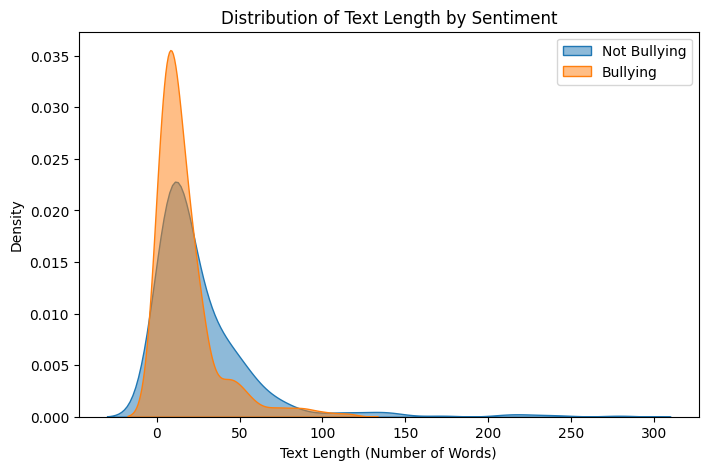

In [7]:
df['length'] = df['text'].apply(lambda x: len(x.split()))

not_bully = df.loc[df['cyberbullying'] == 0]
bully = df.loc[df['cyberbullying'] == 1]

plt.figure(figsize=(8, 5))

sns.kdeplot(not_bully['length'], fill=True, label='Not Bullying', alpha=0.5)
sns.kdeplot(bully['length'], fill=True, label='Bullying', alpha=0.5)

plt.title('Distribution of Text Length by Sentiment')
plt.xlabel('Text Length (Number of Words)')
plt.ylabel('Density')
plt.legend()
plt.show()

In [8]:
summary = pd.DataFrame({
    'Not Bullying': not_bully['length'].describe(),
    'Bullying' : bully['length'].describe()
})

summary

,Not Bullying,Bullying
count,405.000000,245.000000
mean,27.002469,17.146939
std,34.281342,18.586827
min,1.000000,1.000000
25%,8.000000,6.000000
50%,15.000000,11.000000
75%,34.000000,21.000000
max,279.000000,115.000000


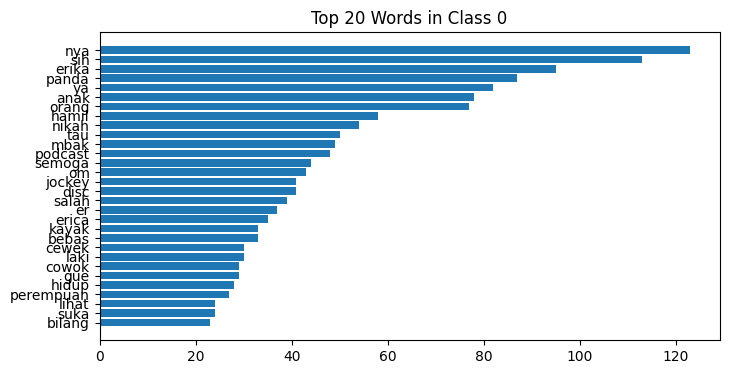

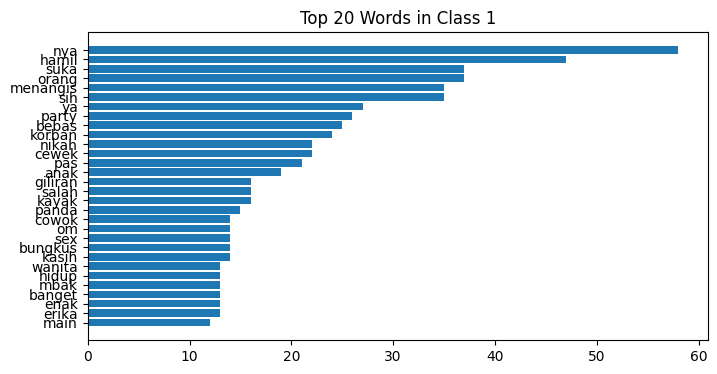

In [7]:
stopwords_id = stopwords.words('indonesian')

for sentiment in sorted(df['cyberbullying'].unique()):
    text = " ".join(df[df['cyberbullying'] == sentiment]['text'])
    
    vectorizer = CountVectorizer(stop_words=stopwords_id)
    X = vectorizer.fit_transform([text])
    freqs = pd.DataFrame({
        'word': vectorizer.get_feature_names_out(),
        'count': X.toarray().flatten()
    }).sort_values('count', ascending=False).head(30)

    plt.figure(figsize=(8,4))
    plt.barh(freqs['word'], freqs['count'])
    plt.gca().invert_yaxis()
    plt.title(f'Top 20 Words in Class {sentiment}')
    plt.show()

In [9]:
top_words = {} 

for sentiment in sorted(df['cyberbullying'].unique()):
    text = " ".join(df[df['cyberbullying'] == sentiment]['text'])
    
    vectorizer = CountVectorizer(stop_words=stopwords_id)
    X = vectorizer.fit_transform([text])
    
    freqs = pd.DataFrame({
        'word': vectorizer.get_feature_names_out(),
        'count': X.toarray().flatten()
    }).sort_values('count', ascending=False).head(30)

    top_words[sentiment] = set(freqs['word'])

not_bully = top_words[0]
bully = top_words[1]

# kata yang muncul di kedua label
common_all = not_bully & bully 

# kata yang hanya muncul di masing-masing label saja
unique_non = not_bully - bully
unique_bully  = bully - not_bully

print('Kata dari top 20 yang ada di kedua label: ',common_all)
print('Kata dari top 20 yang ada label Not Bullying saja: ',unique_non)
print('Kata dari top 20 yang ada label Bullying saja: ',unique_bully)


Kata dari top 20 yang ada di kedua label:  {'kayak', 'sih', 'hidup', 'hamil', 'ya', 'salah', 'panda', 'nya', 'suka', 'cewek', 'cowok', 'nikah', 'bebas', 'erika', 'om', 'anak', 'orang', 'mbak'}
Kata dari top 20 yang ada label Not Bullying saja:  {'laki', 'semoga', 'podcast', 'bilang', 'er', 'erica', 'lihat', 'perempuan', 'jockey', 'tau', 'disc', 'gue'}
Kata dari top 20 yang ada label Bullying saja:  {'giliran', 'kasih', 'korban', 'menangis', 'wanita', 'party', 'sex', 'enak', 'pas', 'main', 'bungkus', 'banget'}


Berdasarkan daftar top 20 kata yang paling sering muncul pada masing-masing kelas, terlihat pola yang cukup mencerminkan karakteristik kedua label.

Pada kedua label (Bullying dan Not Bullying) terdapat sejumlah kata yang bersifat umum, seperti 'kayak', 'sih', 'hidup', 'hamil', 'ya', 'salah', 'panda', 'nya', 'suka', 'cewek', 'cowok', 'nikah', 'bebas', dan beberapa kata lain. Kata-kata ini merupakan kosakata percakapan sehari-hari yang tidak secara langsung mengindikasikan apakah komentar tersebut termasuk bullying atau tidak. Kemunculannya di kedua label menunjukkan bahwa konteks kalimat lah yang lebih menentukan, bukan hanya kata individual.

Sementara itu, pada label Not Bullying, kata-kata yang muncul cenderung bersifat informatif atau netral, seperti 'laki', 'semoga', 'podcast', 'bilang', 'er', 'erica', 'lihat', 'perempuan', 'jockey', 'tau', 'disc', 'gue'. Kata-kata ini sering digunakan dalam komentar yang membahas opini, klarifikasi, atau deskripsi peristiwa tanpa niat menyerang.

Di sisi lain, label Bullying didominasi oleh kata-kata yang memiliki muatan emosional atau konotasi negatif, misalnya 'giliran', 'kasih', 'korban', 'menangis', 'wanita', 'party', 'sex', 'enak', 'pas', 'main', 'bungkus', 'banget'. Kata-kata ini sering muncul pada komentar yang menyerang, merendahkan, atau menyindir seseorang—khususnya karena dataset ini berasal dari percakapan YouTube yang berkaitan dengan kasus Bravy–Erica. Maka tidak mengherankan jika kata seperti “erica”, “wanita”, atau kata berkonotasi seksual muncul lebih dominan pada komentar yang diklasifikasikan sebagai bullying.


In [10]:
weird_texts = df[df['text'].apply(lambda x: bool(re.search(r'[^\x00-\x7F]', str(x))))]

print('Kata bukan ASCII: \n', weird_texts['text'].unique())
print('\nJumlah kalimat: ', weird_texts['text'].nunique())

Kata bukan ASCII: 
 ['Om ded kasih panggung ke cewek problematik biaya hidup idealnya 500 juta perbulan 😂😂😂'
 'Ya Allah,jauhkan anak anak kita dari pergaulan bebas,dari dunia malam,dari hubungan tanpa status 😢😢😢'
 'Aku sedikit pun tidak bersimpati ke sih Erika ini... Sudah boleh ku tebak,hidup nya pun pergaulan bebas gonta ganti jantan.... Sok sok mau nagis cari simpati... 😅😅😅😅'
 'Cuma di Indonesia, skandal beginian dibela mati matian. Selamat datang guys 😂😂'
 'Waktu buat  pas Enak" nya diam" ,pas ,hamil nya berbicara"😅'
 'Kalau anak sekolah dasar di per**** , wajar di kasih pnggung untuk mencari keadilan, lah ini Dia yang sadar, suka party Malah cari empati🥱'
 'Pemain kok di kasih panggung,apa podcast ini cocok buat pintar people 😢bukan tidak berempati sesama wanita cuma malas hidup banyak drama'
 'Biasanya yang kayak begini menangis”nya sebentar, kitanya masih sedih orang nya sudah party”'
 'Semua pasti pernah melakukan kesalahan,, apapun yang terjadi kamu sudah berani bertanggung ja

Problem: 
1. Emot
2. New line
3. Duplikasi (!!!! -> !)
4. Singkatan
5. Pangkat (sama2, ditanya^2)
6. Sarkasme

Karena berdasarkan hasil, bahwa problem di youtube hampir sama dan lebih sedikit dengan problem di twitter maka kita akan menggunakan metode cleaning yang hampir sama dengan data twitter

## Preprocessing

In [11]:
def clean_text_bert(text):

    # 1. Normalisasi unicode, hapus simbol aneh
    text = unicodedata.normalize("NFKD", text)
    text = "".join([c for c in text if c.isprintable()])

    # 3. Decode HTML entities
    text = html.unescape(text)

    # Hapus pola seperti xf2, xe1, x9z (dimulai dengan x + 2 char)
    text = re.sub(r'\bx[a-zA-Z0-9]{2}\b', ' ', text)

    # 9. Hapus duplikasi huruf berlebih: Nabuuunggg -> Nabung
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # 10. Hapus duplikasi tanda tanya/seru: ??? -> ?
    text = re.sub(r'([?!])\1+', r'\1', text)

    # 11. Hapus punctuation KECUALI: huruf, angka, spasi, ., ?, !
    #     Tapi tetap pertahankan "." pada angka (1.200.000)
    text = re.sub(r'[^0-9A-Za-z?!.\s/]', ' ', text)

    # 12. Hapus titik yang tidak berada di dalam angka
    text = re.sub(r'(?<!\d)\.(?!\d)', ' ', text)

    # 13. Bersihkan spasi berlebihan
    text = re.sub(r'\s+', ' ', text).strip()

    return text

stop_factory = StopWordRemoverFactory()
stopwords_id = stop_factory.get_stop_words()

def clean_text_ml(text):

    text = str.lower(text)
    
    # 1. Normalisasi unicode & hapus simbol aneh
    text = text.encode('ascii', errors='ignore').decode()
    
    # 2. Hapus penyebutan nama
    text = re.sub(r'\b(er|erica|)\b', '', text, flags=re.IGNORECASE)

    # Hapus pola seperti xf2, xe1, x9z (dimulai dengan x + 2 char)
    text = re.sub(r'\bx[a-zA-Z0-9]{2}\b', ' ', text)
    
    # 3. Hapus hashtag tapi simpan kata
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # 4. Hapus semua angka
    text = re.sub(r'\d+', ' ', text)
    
    # 5. Hapus semua punctuation
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # 6. Hapus stopwords bahasa Indonesia
    words = text.split()
    words = [w for w in words if w.lower() not in stopwords_id]
    
    # 7. Hapus duplikasi huruf berlebih: Nabuuunggg -> Nabung
    words = [re.sub(r'(.)\1{2,}', r'\1', w) for w in words]
    
    # 8. Bersihkan spasi
    text = ' '.join(words)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


In [12]:
df['clean_text_bert'] = df['text'].apply(lambda x: clean_text_bert(x))
df['clean_text_ML'] = df['text'].apply(lambda x: clean_text_ml(x))
df.head()

,text,cyberbullying,clean_text_bert,clean_text_ML
0,Kalau cowok sudah sakit hati dan kecewa memang...,0,Kalau cowok sudah sakit hati dan kecewa memang...,kalau cowok sakit hati kecewa memang kayak mbak
1,Om ded kasih panggung ke cewek problematik bia...,1,Om ded kasih panggung ke cewek problematik bia...,om ded kasih panggung cewek problematik biaya ...
2,om ded?? apa are kamu doing !!!!!!!!!!!!!,0,om ded? apa are kamu doing !,om ded apa are kamu doing
3,"Ya Allah,jauhkan anak anak kita dari pergaulan...",0,Ya Allah jauhkan anak anak kita dari pergaulan...,allah jauhkan anak anak pergaulan bebas dunia ...
4,"gue kira pintar people, tetapi hal kayak begin...",0,gue kira pintar people tetapi hal kayak begini...,gue kira pintar people kayak begini angkat pod...


In [13]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
nlp = stanza.Pipeline(lang='id', processors='tokenize,pos,lemma,depparse', use_gpu=False)

def rm_subject_stanz(text):
    # Hapus kata subject (nsubj / csubj) dari teks bahasa Indonesia menggunakan dependency parsing Stanza.

    # 1. Proses teks
    doc = nlp(text)
    
    # 2. Filter kata, hapus subject berdasarkan deprel
    filtered_tokens = []
    for sent in doc.sentences:
        for word in sent.words:
            if word.deprel not in ['nsubj', 'csubj']:
                filtered_tokens.append(word.lemma)  # gunakan lemma agar kata bentuk dasar
    
    # 3. Gabungkan kembali menjadi string & bersihkan spasi
    cleaned_text = ' '.join(filtered_tokens)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text

2025-12-11 13:21:27 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-12-11 13:21:27 INFO: Downloaded file to /Users/jowillg/stanza_resources/resources.json
2025-12-11 13:21:27 WARNING: Language id package default expects mwt, which has been added
2025-12-11 13:21:28 INFO: Loading these models for language: id (Indonesian):
| Processor | Package      |
----------------------------
| tokenize  | gsd          |
| mwt       | gsd          |
| pos       | gsd_charlm   |
| lemma     | gsd_nocharlm |
| depparse  | gsd_charlm   |

2025-12-11 13:21:28 INFO: Using device: cpu
2025-12-11 13:21:28 INFO: Loading: tokenize
2025-12-11 13:21:28 INFO: Loading: mwt
2025-12-11 13:21:28 INFO: Loading: pos
2025-12-11 13:21:30 INFO: Loading: lemma
2025-12-11 13:21:30 INFO: Loading: depparse
2025-12-11 13:21:30 INFO: Done loading processors!


In [14]:
df['clean_text_ML_2'] = df['clean_text_ML'].apply(lambda x: rm_subject_stanz(x))
df.head()

,text,cyberbullying,clean_text_bert,clean_text_ML,clean_text_ML_2
0,Kalau cowok sudah sakit hati dan kecewa memang...,0,Kalau cowok sudah sakit hati dan kecewa memang...,kalau cowok sakit hati kecewa memang kayak mbak,kalau cowok sakit hati kecewa memang kayak mbak
1,Om ded kasih panggung ke cewek problematik bia...,1,Om ded kasih panggung ke cewek problematik bia...,om ded kasih panggung cewek problematik biaya ...,om ded kasih panggung cewek problematik biaya ...
2,om ded?? apa are kamu doing !!!!!!!!!!!!!,0,om ded? apa are kamu doing !,om ded apa are kamu doing,om ded apa are kamu doing
3,"Ya Allah,jauhkan anak anak kita dari pergaulan...",0,Ya Allah jauhkan anak anak kita dari pergaulan...,allah jauhkan anak anak pergaulan bebas dunia ...,jauh anak anak gaul bebas dunia malam hubung s...
4,"gue kira pintar people, tetapi hal kayak begin...",0,gue kira pintar people tetapi hal kayak begini...,gue kira pintar people kayak begini angkat pod...,gue kira pintar people kayak begini angkat pod...


### Kata yang paling sering muncul di kedua kelas

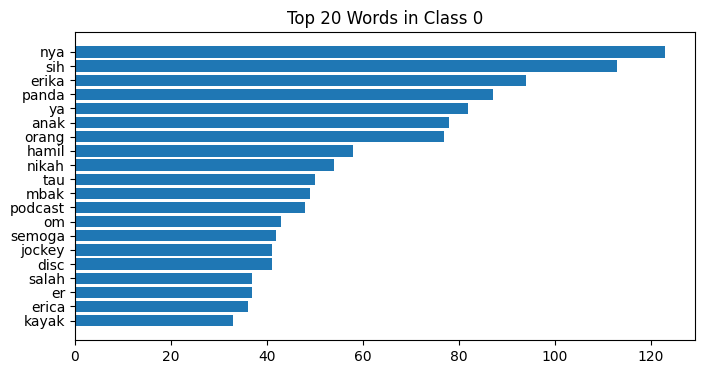

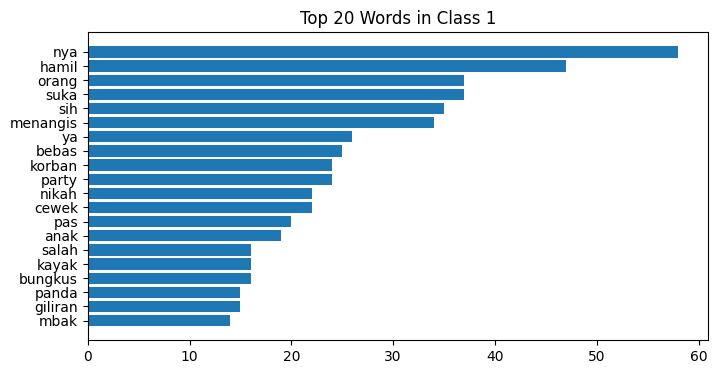

In [15]:
stopwords_id = stopwords.words('indonesian')

for sentiment in sorted(df['cyberbullying'].unique()):
    text = " ".join(df[df['cyberbullying'] == sentiment]['clean_text_bert'])
    
    vectorizer = CountVectorizer(stop_words=stopwords_id)
    X = vectorizer.fit_transform([text])
    freqs = pd.DataFrame({
        'word': vectorizer.get_feature_names_out(),
        'count': X.toarray().flatten()
    }).sort_values('count', ascending=False).head(20)

    plt.figure(figsize=(8,4))
    plt.barh(freqs['word'], freqs['count'])
    plt.gca().invert_yaxis()
    plt.title(f'Top 20 Words in Class {sentiment}')
    plt.show()

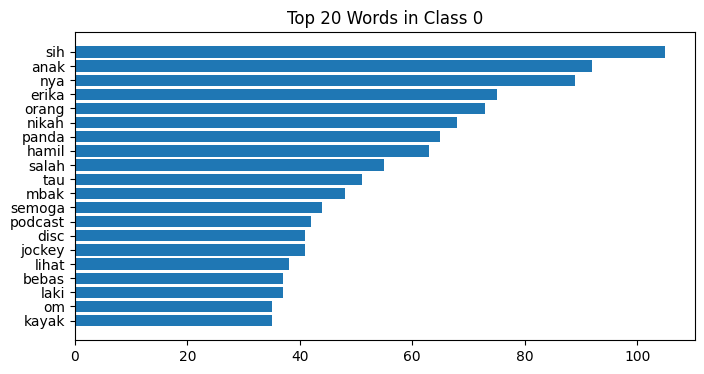

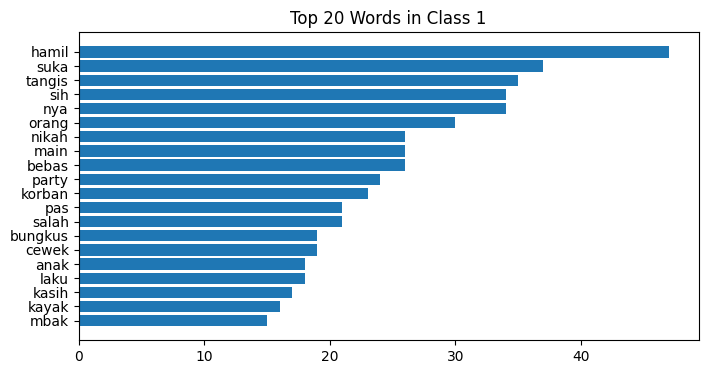

In [16]:
stopwords_id = stopwords.words('indonesian')

for sentiment in sorted(df['cyberbullying'].unique()):
    text = " ".join(df[df['cyberbullying'] == sentiment]['clean_text_ML_2'])
    
    vectorizer = CountVectorizer(stop_words=stopwords_id)
    X = vectorizer.fit_transform([text])
    freqs = pd.DataFrame({
        'word': vectorizer.get_feature_names_out(),
        'count': X.toarray().flatten()
    }).sort_values('count', ascending=False).head(20)

    plt.figure(figsize=(8,4))
    plt.barh(freqs['word'], freqs['count'])
    plt.gca().invert_yaxis()
    plt.title(f'Top 20 Words in Class {sentiment}')
    plt.show()

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             650 non-null    object
 1   cyberbullying    650 non-null    int64 
 2   clean_text_bert  650 non-null    object
 3   clean_text_ML    650 non-null    object
 4   clean_text_ML_2  650 non-null    object
dtypes: int64(1), object(4)
memory usage: 25.5+ KB


## Output ke CSV
Nama file: final_data_yt.csv

In [ ]:
# import csv
# df.to_csv("data/final_data_yt.csv", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)